# Probe combination in CosmoBolognaLib 

**WARNING:** to run this notebook, the user must run 'make modelpy PY=python3' in this folder.

In this notebook we show how to perform the <b>combination</b> of <b>independent</b> probes in CosmoBolognaLib with 3 different methods.
Let'say you have a set of parameters $\vec{\theta}$ you want to constrain having $N$ datasets $\mathcal{D}_j$. Given the priors $\mathcal{Pr}(\vec{\theta})$ on these parameters and the likelihood function $\mathcal{L}(\mathcal{D}_j|\vec{\theta})$, the posterior distribution $P(\vec{\theta}|\mathcal{D}_j)$ on the parameters given the data is:

$P(\vec{\theta}|\mathcal{D}_j) \propto \mathcal{L}(\mathcal{D}_j|\vec{\theta})\mathcal{Pr}(\vec{\theta})$

In this notebook we will consider the combination of different posterior distributions, considering the datasets as <i>statistically independent</i>. This means that we make no assumption on the covariance matrix between the different datasets. You can perform such a combination in the CosmoBolognaLib with the following three methods:

1) <b>Importance sampling</b>: in this method each point in the parameter-space (e.g the $\Omega_m$-$\sigma_8$ plane) has a weight computed as the ratio between the posterior distributions of the two probes at that point. We have to evaluate the posterior distribution of one probe in the points of the other and viceversa, then we have to concatenate the resulting chains. We present also how to perform importance sampling from two pre-runned chains (hence by reading them from the MCMC outputs). We will refer to this method as <b>A-posteriori Importance sampling</b>; 

2) <b>log(Posterior) sum</b>: here, for every step chain, we perform the summation of $\log(\text{Posterior})$ distributions of the two input objects. This operation is embedded in the sampling posterior's function included in $\verb|cbl::statistics::CombinedPosterior|$;

3) <b>Posterior as Prior</b>: in this case the combination is performed by considering the posterior distribution for a given probe as the prior distribution of the other. In this case a covariance matrix will take into account the correlations between the different parameters. Also in this case, as done for the importance sampling method, the user can decide to read the multivariate prior distribution from external chains (pre-runned). We will refer to this method as <b>Posterior as Prior (from chains)</b>.

The three methods listed above require datasets and models to run the chains while the <i>A-posteriori importance sampling</i> and the <i>Posterior as Prior (from chains)</i> methods read pre-runned chains, hence we are going to treat them independently from the others.

At the and of the notebook we show the comparison between the different combination methods.

## Import modules

In [1]:
# to ensure compatibility in Python versions 2.x and 3.x
from __future__ import print_function

import CosmoBolognaLib as cbl

import numpy as np
import sys
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# import corner for contours plot
import corner

# import the wrapper that returns an object of type Model1D
from modelpy import getModel1D
from modelpy import getModel1D_correlated

from CosmoBolognaLib import DoubleVector as dv
from CosmoBolognaLib import DoubleVectorVector as dvv

# to show the standard output stream of the CBL functions on notebook cells
#%load_ext wurlitzer

## Set the I/O paths

In [2]:
dir_input = "../input/"
dir_output = "../output/"
file_data1 = "data1.dat"
file_data2 = "data2.dat"

## Construct datasets & models

In this notebook we consider, as our example probes ($A$ and $B$), two linear fit, described by the same set of parameters $\vec{\theta} = \{A, B, C, D\}$, on two different datasets. The two models are:

$y_A = C \cdot x_A + D + A \cdot \Omega_m$

$y_B = - C \cdot x_B + D + A \cdot \Omega_m$

The parameter $A$ will be considered as <b>constant</b>, fixed at $A = 1$, while the parameter $B$ as <b>derived</b>. Indeed we define it as the sum of all the others parameters:

$B = A + C + D$

In order to construct the models described above, we need to create an object of the class $\verb|cbl::Cosmology|$. Without specifying any parameters in the constructor of this class, the Planck cosmology will be used (https://arxiv.org/abs/1303.5076).

In [3]:
# set the guess values for the parameters
valA, valC, valD = 1., 1., 2.

# limits for C and D
minC, maxD = -10., 10.
minD, maxC = -10., 10.

cosmology = cbl.Cosmology()

# construct the dataset by reading an input file
data1 = cbl.Data1D(dir_input+file_data1)
data2 = cbl.Data1D(dir_input+file_data2)

# construct the models
model1 = getModel1D(cosmology, 0)
model2 = getModel1D(cosmology, 1)

### Plot the datasets

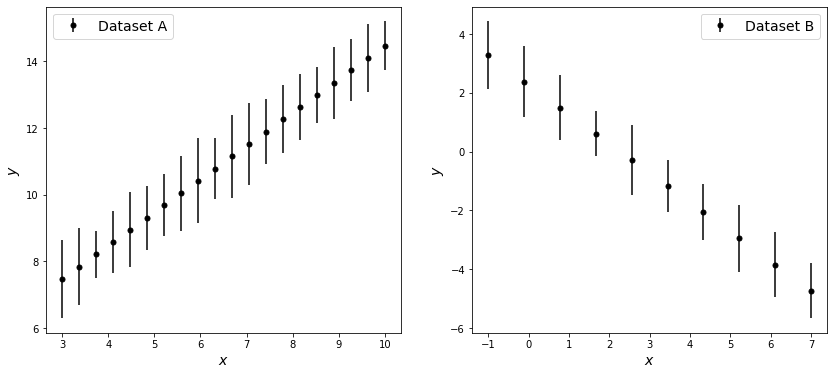

In [4]:
x_A, y_A, err_A = np.genfromtxt(dir_input+file_data1, usecols=(0,1,2), unpack=True)
x_B, y_B, err_B = np.genfromtxt(dir_input+file_data2, usecols=(0,1,2), unpack=True)

fig = plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.errorbar(x_A, y_A, yerr=err_A, color='k', marker='.', markersize=10, linestyle='', label='Dataset A')
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plt.subplot(1,2,2)
plt.errorbar(x_B, y_B, yerr=err_B, color='k', marker='.', markersize=10, linestyle='', label='Dataset B')
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

## Construct likelihoods & priors

In [5]:
# define a Gaussian likelihood
likelihood1 = cbl.Likelihood(data1, model1, cbl.LikelihoodType__Gaussian_Error_)
likelihood2 = cbl.Likelihood(data2, model2, cbl.LikelihoodType__Gaussian_Error_)

# construct the priors
prior_A = cbl.PriorDistribution(cbl.DistributionType__Constant_, valA)
prior_C = cbl.PriorDistribution(cbl.DistributionType__Uniform_, minC, maxC)
prior_D = cbl.PriorDistribution(cbl.DistributionType__Uniform_, minD, maxD)


prior_distributions = cbl.PriorDistributionPtrVector([prior_A, prior_C, prior_D])

## Construct Posterior objects

In order to combine together two posterior objects, we need to put them into a single vector, which then will be passed to the constructor of the $\verb|CombinedPosterior|$ class.

In [6]:
# construct the posteriors
PostA = cbl.Posterior(prior_distributions, likelihood1, 696)
PostB = cbl.Posterior(prior_distributions, likelihood2, 696)

# put them into a pointer vector
ptr_posteriors = cbl.PosteriorPtrVector([PostA, PostB])

## Combine Posterior objects: 1) importance sampling

In this method we run the MCMC chain and, for each chain step, we evaluate the ratio between the two posterior distributions (<i>importance weight</i>) in a generic parameter-space point $\vec{\theta}_i$. For the two probes $A$ and $B$, we have to compute the importance weight in both directions and then concatenate them. This means that we have to sample firstly the posterior distribution $A$, which associated points in the parameter space are indicated as $\{\vec{\theta}_A\}$, and compute the ratio between the posterior of $A$ and that of $B$ in every point $\vec{\theta}_i \in \{\vec{\theta}_A\}$ as

$w_{A+B} = \frac{\max \{ P_A(\vec{\theta}_A) \}}{\max \{ P_B(\vec{\theta}_A) \}}\frac{P_B(\vec{\theta_A})}{P_A(\vec{\theta_A})} = exp(\log P_B(\vec{\theta_A}) - \log P_A(\vec{\theta_A}) + \lambda_{max}^{A+B})$

where:

$\lambda_{max}^{A+B} = max(\log P_A(\vec{\theta_A})) - max(\log P_B(\vec{\theta_A}))$;

And then we have to do the same thing but in the other direction, i.e in the set of points $\vec{\theta}_i \in \{ \vec{\theta}_B \}$:

$w_{B+A} = \frac{\max \{ P_B(\vec{\theta}_B) \}}{\max \{ P_A(\vec{\theta}_B) \}}\frac{P_A(\vec{\theta_B})}{P_B(\vec{\theta_B})} = exp(\log P_A(\vec{\theta_B}) - \log P_B(\vec{\theta_B}) + \lambda_{max}^{B+A})$

where now:

$\lambda_{max}^{B+A} = max(\log P_B(\vec{\theta_B})) - max(\log P_A(\vec{\theta_B}))$;

Lastly, we will have a final chain containing the posterior distribution evaluated at the set of points $\{ \vec{\theta_A}\}$ concatenated with that evaluated at $\{ \vec{\theta}_B \}$, with the importance weight specified for each chain step.

### Combine

The method described above is performed inside the function $\verb|importance|$\_$\verb|sampling|$ of the $\verb|CombinedPosterior|$ class.

In [7]:
# construct the combination object by passing the pointer vector
CombPost = cbl.CombinedPosterior(ptr_posteriors)

# set parameters for posterior sampling
nwalkers = 8
chain_size = 7500
burn_in = 200
thin = 1

# set a starting point for the MCMC
start = [valC, valD]

# perform the importance sampling
CombPost.importance_sampling(dir_output, "model1", "model2", start, chain_size, nwalkers, burn_in, thin)

### Write & show results for importance sampling

In [8]:
# write results for importance sampling
CombPost.write_results(dir_output, "impsamp", burn_in, thin)

# show results for importance sampling
CombPost.show_results(burn_in, thin)

## Combine Posterior objects: 1.1) A-posteriori importance sampling

In this case we read two external MCMC output files (pre-runned) and perform importance sampling between the two $\log(\text{Posterior})$ distributions. In order to do this we need the log(Posterior) of one MCMC in the points of the other and viceversa. By reading the chains externally, we do not have such informations, therefore we need to interpolate a given $\log(\text{Posterior})$ in the points of the other by using the function $\verb|interpolate|$ of the $\verb|cbl::ChainMesh|$ class. This latter function perform a $N$-dimensional interpolation, and it is called within the $\verb|importance|$\_$\verb|sampling|$ function of the $\verb|CombinedPosterior|$ class.
Finally, the importance weights are computed as the previously described importance sampling method.

### Construct Posterior objects by reading from external files

In [9]:
#pre-runned chains file names
file_A = "model1_chain.dat"
file_B = "model2_chain.dat"

# choose the columns that you want to read --> starting from 1, last one for the log(Posterior)
usecols = [3,4,5,8]

param_names = ['B', 'C', 'D']

skip_header = 1

PostA = cbl.Posterior(file_A, dir_output, usecols, param_names, skip_header)
PostB = cbl.Posterior(file_B, dir_output, usecols, param_names, skip_header)

# put them into a pointer
ptr_posteriors_IS = cbl.PosteriorPtrVector([PostA, PostB])

### Combine

As already mentioned, the computation of the importance weights is done via a $N$-dimensional interpolation. The latter is done in a mesh grid, which is set to be regular (squared/cubic/..) with given box side lenght of $200$ units ($-100$ to $100$). The user can set the size of the cells in this grid.
Given a point in the parameter space $\vec{\theta}_i$, the $\verb|interpolate|$ function will search for the $\verb|distNum|$ closest points within the cells enclosed in a region of radius $\verb|rMAX|$, which both are settable by the user.
Finally, since the importance weight is defined as a ratio, and the posteriors are discrete distributions, it is possible to encounter spikes in the weights distribution. The user can set the number of standard deviations ($\sigma_w$) of this distribution that has to be considered, in order to avoid them.

In [10]:
# construct the combination object by passing the pointer
CombPost_ext = cbl.CombinedPosterior(ptr_posteriors_IS)

# define the parameter for the interpolation
distNum = 200
cell_size = 2.
rMAX = 4.

# the number of sigma that you want to consider in order to avoid spikes. cut_w = -1 --> no cut
cut_w = 3.

# perform the importance sampling
CombPost_ext.importance_sampling(distNum, cell_size, rMAX, cut_w)

### Write & show results for A-posteriori importance sampling

In [11]:
# write the resulting chain on a output file
CombPost_ext.write_results(dir_output, "ext_impsamp", 0, 1)

# show results on the screen
CombPost_ext.show_results(0, 1)

## Combine Posterior objects: 2) log(Posterior) sum

In this method we run the MCMC chain and, for each chain step $\vec{\theta}_i$, we evaluate the resulting $\log(\text{Posterior})$ distribution as the sum of the $\log(\text{Posterior})$ of the objects given in input. Having $N$ different probes:

$log(P_{fin}(\vec{\theta}_i)) = \sum_{j=1}^{N} log(P_j(\vec{\theta}_i))$

In terms of likelihoods $\mathcal{L}$ and priors $\mathcal{Pr}$:

$log(P_{fin}(\vec{\theta}_i) = \sum_{j=1}^{N} log(\mathcal{L}_j(\vec{\theta}_i)) + log(\mathcal{Pr}(\vec{\theta}_i))$

### Combine (sample the posterior)

This combination is done inside the $\verb|sample|$\_$\verb|stretch|$\_$\verb|move|$ function, which perform the Stretch Move algorithm described in Goodman & Weare 2010 (https://ui.adsabs.harvard.edu/abs/2010CAMCS...5...65G/abstract) and in Foreman-Mackey 2012 (https://arxiv.org/pdf/1202.3665.pdf), implemented in the $\verb|CombinedPosterior|$ class.

In [12]:
# construct the combination object by passing the pointer
CombPost_sum = cbl.CombinedPosterior(ptr_posteriors)

# Initialize the chains
CombPost_sum.initialize_chains(chain_size, nwalkers, 1.e-5, start)

# Sampling the posterior
CombPost_sum.sample_stretch_move(2)

### Write & show results for log(Posterior) sum

In [13]:
#write results for importance sampling
CombPost_sum.write_results(dir_output, "logpost_sum", burn_in, thin)

#show results for importance sampling
CombPost_sum.show_results(burn_in, thin)

## Combine Posterior objects: 3) Posterior as Prior

In this method we consider the MCMC output of the probe A for the varying parameters $C$ and $D$, i.e their distribution in the parameter space, as the prior for the probe B. In order to recover the correlation between this two parameters we have to compute the <b>covariance matrix</b> of them.

### Obtain the covariance matrix of the model parameters

In [14]:
file_A = "model1_chain.dat"
file_B = "model2_chain.dat"

# same as getModel1D, but C and D are correlated with each other
#model2_corr = getModel1D_correlated(cosmology, 1)       #<--- for Posterior A as Prior B
model1_corr = getModel1D_correlated(cosmology, 0)        #<--- for Posterior B as Prior A

# read C and D from the MCMC output of first model
#C_, D_ = np.genfromtxt(dir_output+file_A, usecols=(3,4), unpack=True)    #<--- For Posterior A as Prior B
C_, D_ = np.genfromtxt(dir_output+file_B, usecols=(3,4), unpack=True)      #<--- For Posterior B as Prior A

# covariance matrix
cov = np.cov(np.stack((C_, D_), axis=0))

print("Covariance matrix of C and D\n")
print (cov)

# get the median, the std dev, and extremals of each parameter
Mean = np.median(list(zip(C_, D_)), axis=0)
Std = np.std(list(zip(C_, D_)), axis=0)
Min = np.min(list(zip(C_, D_)), axis=0)
Max = np.max(list(zip(C_, D_)), axis=0)

# save the covariance matrix in a vector<vector<double>>
covM = dvv([list(cov[0]),list(cov[1])])

Covariance matrix of C and D

[[0.01746821 0.0541406 ]
 [0.0541406  0.26707971]]


### Construct the Likelihood functions, the Priors and the Posterior objects

The sampling of the posterior will occur only for the probe B, so we construct the likelihood function with the dataset B and the model B defined above. The prior distribution for the parameters $\vec{\theta} = \{C, D\}$ will be a Multivariate Gaussian Distribution (MGD). By specifying the vector of medians $\vec{\mu} = \{\bar{C}, \bar{D}\}$ and the covariance matrix $\Sigma$, the MGD reads:

$\mathcal{Pr}(\vec{\theta}) \equiv \mathcal{G}(\vec{\theta}|\vec{\mu}, \Sigma) = \frac{1}{(2\pi)^{n/2}\sqrt{|\Sigma^{-1}|}}\exp{\biggl[-\frac{1}{2}(\vec{\theta} - \vec{\mu})^T \Sigma (\vec{\theta} - \vec{\mu})\biggr]}$

In [15]:
# construct the likelihood function as gaussian by passing the 2nd dataset and the "correlated model"
likelihood_corr = cbl.Likelihood(data1, model1_corr, cbl.LikelihoodType__Gaussian_Error_)   #<--- For Posterior B as Prior A
#likelihood_corr = cbl.Likelihood(data2, model2_corr, cbl.LikelihoodType__Gaussian_Error_)  #<--- For Posterior A as Prior B

# set the prior as multivariate gaussian distributed, specifing the statistics of C and D parameters
prior_corr = cbl.PriorDistribution(cbl.DistributionType__Gaussian_, dv(Mean), covM, dv([minC,minD]), dv([maxC,maxD]));

# put the priors into a single pointer vector
prior_distributions = cbl.PriorDistributionPtrVector([prior_A,prior_corr])

# construct the Posterior object by passing the priors pointer vector and the likelihood
Post_corr = cbl.Posterior(prior_distributions, likelihood_corr, 696)

# initialize chains by choosing a starting point
Post_corr.initialize_chains(chain_size, nwalkers, 1.e-5, start)

### Combine (sample the posterior)

Here the combination is a simple posterior sampling, considering as prior the posterior of the other probe.

In [16]:
# sample the posterior with the Stretch Move algorithm
Post_corr.sample_stretch_move(2)

# show the median MCMC values of the four parameters on screen
print ("\n")
for i in range(Post_corr.parameters().nparameters()):
    print("Posterior median of %s = %g\n"%(Post_corr.parameters().name(i), Post_corr.parameters().bestfit_value(i)))
    
# store the chain ouputs
Post_corr.write_results(dir_output, "combined_prior")



Posterior median of A = 1

Posterior median of B = 5.04907

Posterior median of C = 1.17825

Posterior median of D = 2.87058



## Combine Posterior objects: 3.1) Posterior as Prior (read from chains)

This case differs from the previous one by the fact that the external MCMC is read directly in the $\verb|PriorDistribution|$ constructor. In order to have the value of the prior in a generic point $\vec{\theta}_i$ of the parameter space, we need to know the value of the posterior (of the other probe) in that point. Reading externally from chains, we do not have an analytic expression for the posterior distribution, hence we have to interpolate the latter from the external chains, by searching for close points to $\vec{\theta}_i$. Therefore we need again the $\verb|interpolate|$ function of the $\verb|ChainMesh|$ class, which is called inside the $\verb|PriorDistribution|$ constructor.

In [17]:
# set the parameters for the interpolation
distNum = 200
rMAX = 2.
cell_size = 1.

# set a good starting point for the MCMC
start = [1.2,3.]

# construct the prior distribution by interpolate from external chains
#prior_corr = cbl.PriorDistribution(file_A, dir_output, [4,5,8], 1, 0, True, distNum, rMAX, cell_size)    #<--- For Posterior A as Prior B
prior_corr = cbl.PriorDistribution(file_B, dir_output, [4,5,8], 1, 0, True, distNum, rMAX, cell_size)     #<--- For Posterior B as Prior A

# put the priors into a single pointer vector
prior_distributions = cbl.PriorDistributionPtrVector([prior_A, prior_corr])

# construct the posterior object
Post_corr = cbl.Posterior(prior_distributions, likelihood_corr, 696)

# initialize the chains
Post_corr.initialize_chains(chain_size, nwalkers, 1.e-5, start)

### Combine (sample the posterior)

In [18]:
# sample the posterior with the Stretch Move algorithm
Post_corr.sample_stretch_move(2)

print ("\n")
for i in range(Post_corr.parameters().nparameters()):
    print("Posterior median of %s = %g\n"%(Post_corr.parameters().name(i), Post_corr.parameters().bestfit_value(i)))

# store the chains outputs
Post_corr.write_results(dir_output, "combined_prior2")



Posterior median of A = 1

Posterior median of B = 5.05202

Posterior median of C = 1.17964

Posterior median of D = 2.873



## Define function that plots contours in parameter-space

In [19]:
def plot_contours(points, label_probe, weights, color, label_params, figure, axes, ls="solid", lw=1.5):

    range = [(1.8, 8.4), (0.60, 1.38), (0.2,6.4)]

    corner.corner(points, weights=weights, \
           color=color, smooth=True, labels=label_params, range=range, \
           show_titles=True, bins=40, plot_datapoints=False, plot_contours=True, plot_density=True, \
           levels=[0.68, 0.95], fill_contours=True, max_n_ticks = 5, truth_color="k", alpha=0.8, \
           label_kwargs={"fontsize": 23}, title_kwargs={"fontsize": 20}, \
           hist_kwargs={"density" : True, "color":color}, contour_kwargs={"linestyles":ls,"linewidths":lw}, fig=figure)

    axes[0][1].plot(1,1, color, label=label_probe, ls=ls, lw=lw)
    axes[0][1].legend(loc="center left", fontsize=15)

## Extract data and plot contours: compare the different combination methods

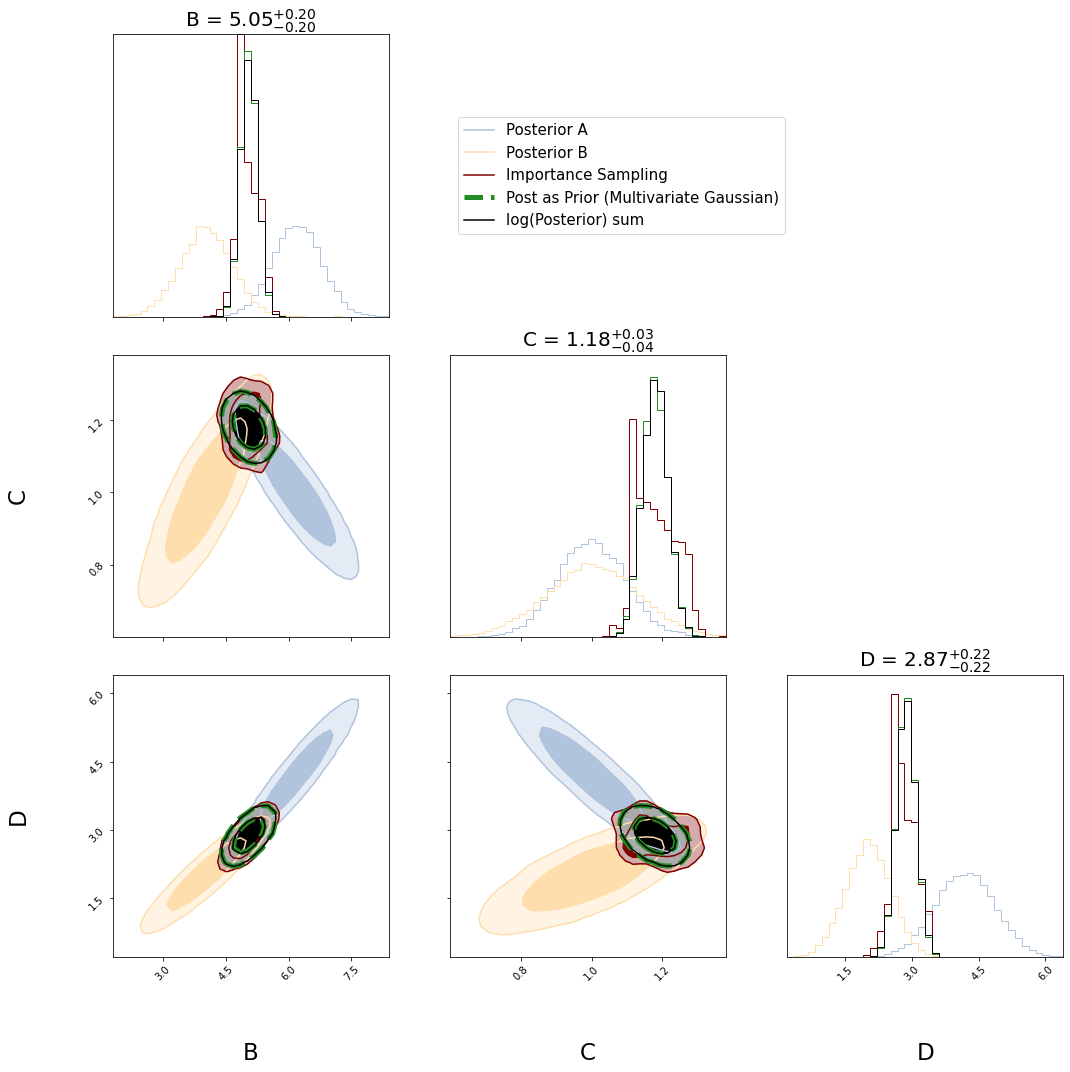

In [20]:
file_PP = "combined_prior_chain.dat"
file_IS = "impsamp_chain.dat"
file_sum = "logpost_sum_chain.dat"

B_1, C_1, D_1 = np.genfromtxt(dir_output+file_A, usecols=(2, 3, 4), unpack=True)
B_2, C_2, D_2 = np.genfromtxt(dir_output+file_B, usecols=(2, 3, 4), unpack=True)
B_IS, C_IS, D_IS, weights = np.genfromtxt(dir_output+file_IS, usecols=(2, 3, 4, 6), unpack=True)
B_PP, C_PP, D_PP = np.genfromtxt(dir_output+file_PP, usecols=(2, 3, 4), unpack=True)
B_sum, C_sum, D_sum = np.genfromtxt(dir_output+file_sum, usecols=(2, 3, 4), unpack=True)

points_A = list(zip(B_1, C_1, D_1))
points_B = list(zip(B_2, C_2, D_2))
points_IS = list(zip(B_IS, C_IS, D_IS))
points_PP = list(zip(B_PP, C_PP, D_PP))
points_sum = list(zip(B_sum, C_sum, D_sum))

col_1 = "lightsteelblue"
col_2 = "navajowhite"
col_IS = "maroon"
col_PP = "forestgreen"
col_sum = "k"

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

plot_contours(points_A, "Posterior A", None, col_1, param_names, fig, axes)
plot_contours(points_B, "Posterior B", None, col_2, param_names, fig, axes)
plot_contours(points_IS, "Importance Sampling", weights, col_IS, param_names, fig, axes)
plot_contours(points_PP, "Post as Prior (Multivariate Gaussian)", None, col_PP, param_names, fig, axes, 'dashed', 5)
plot_contours(points_sum, "log(Posterior) sum", None, col_sum, param_names, fig, axes)

plt.tight_layout()

## Compare importance sampling methods

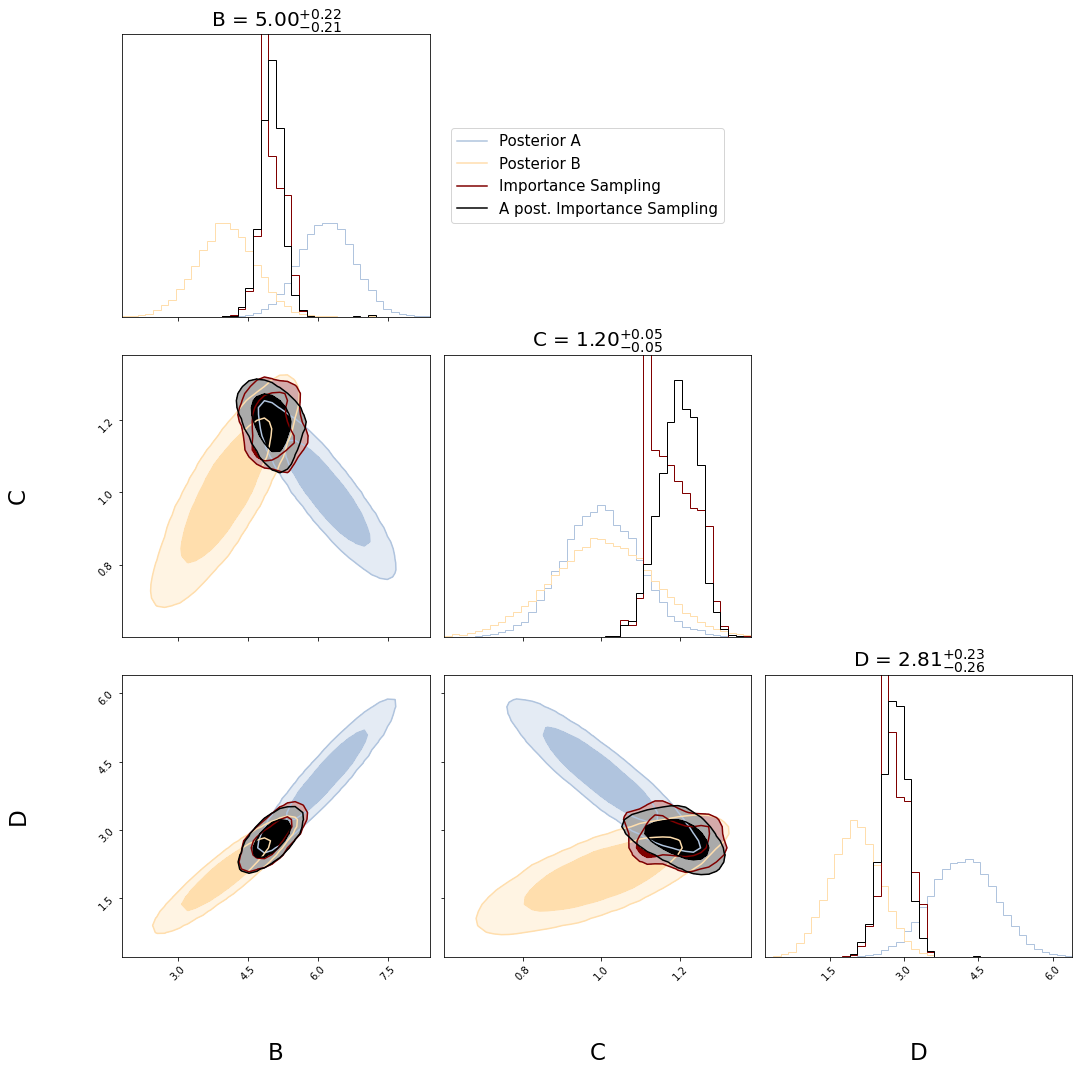

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

file_ext = "ext_impsamp_chain.dat"

B_ext, C_ext, D_ext, w_ext = np.genfromtxt(dir_output+file_ext, usecols=(1, 2, 3, 5), unpack=True)
points_ext = list(zip(B_ext, C_ext, D_ext))

col_ext = "k"

plot_contours(points_A, "Posterior A", None, col_1, param_names, fig, axes)
plot_contours(points_B, "Posterior B", None, col_2, param_names, fig, axes)
plot_contours(points_IS, "Importance Sampling", weights, col_IS, param_names, fig, axes)
plot_contours(points_ext, "A post. Importance Sampling", w_ext, col_ext, param_names, fig, axes)

plt.tight_layout()

## Compare Posterior as Prior methods

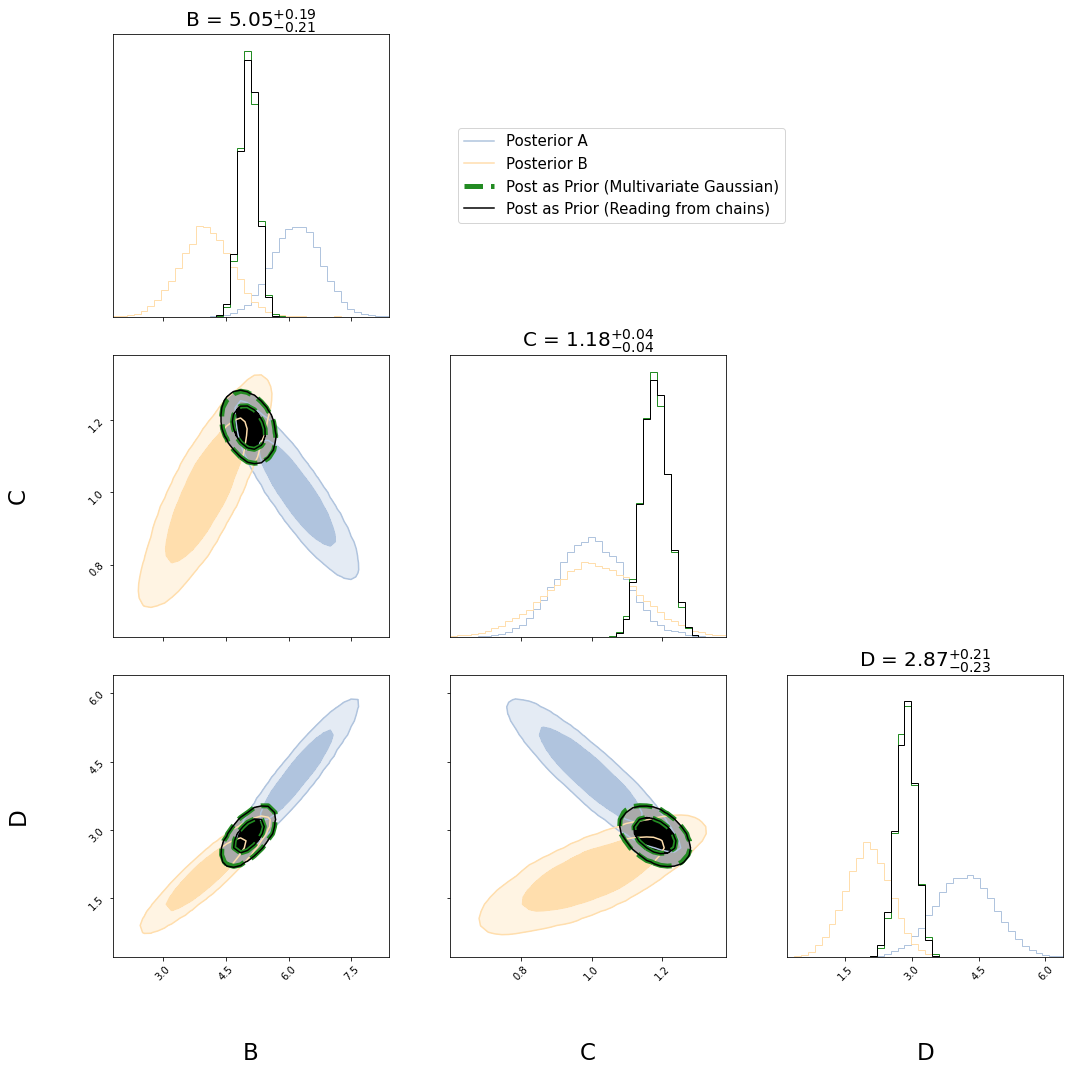

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

file_PP2 = "combined_prior2_chain.dat"

col_PP2 = "k"

B_PP2, C_PP2, D_PP2 = np.genfromtxt(dir_output+file_PP2, usecols=(2, 3, 4), unpack=True)

points_PP2 = list(zip(B_PP2, C_PP2, D_PP2))

plot_contours(points_A, "Posterior A", None, col_1, param_names, fig, axes)
plot_contours(points_B, "Posterior B", None, col_2, param_names, fig, axes)
plot_contours(points_PP, "Post as Prior (Multivariate Gaussian)", None, col_PP, param_names, fig, axes, ls="dashed", lw=5)
plot_contours(points_PP2, "Post as Prior (Reading from chains)", None, col_PP2, param_names, fig, axes)

plt.tight_layout()